In [1]:
import numpy as np
from PIL import Image
from PIL.Image import Resampling
from PIL.Image import Palette
import os
import json
import pyrle
from itertools import groupby

%matplotlib inline

## Encoding

DPPt spritesheets grabbed from here: <https://www.spriters-resource.com/ds_dsi/pokemonplatinum/>
The HGSS ones also work, if you prefer <https://www.spriters-resource.com/ds_dsi/pokemonheartgoldsoulsilver/sheet/132565/>

Sprites are written as a palette of 16 colours, followed by the indexed colour image data, packed to 2 pixels per byte.
By default, it writes the 16-bit palette meant for the colour OLED but you can easily modify it to write the RGB palette. Just make sure you change the sizes on the decoding end.

```c
struct image {
    uint16_t palette[16];
    uint8_t data[] // packed to 2 pixels per byte, length depends on size of image
}
```

In [2]:
def img_to_palette(img):
    data = np.array(img.convert("RGB")).reshape((-1,3))
    
    ## get palette
    #colours = np.unique(data, axis=1)
    colours = np.array(img.quantize(colors=16).getpalette()).reshape((-1,3))[:16]
    #print(f"colours: {colours}, {len(colours)}")
    
    ## convert to indexed colour image
    indexed = np.zeros(len(data), dtype=np.uint8)
    for i, c in enumerate(colours):
        indexed[np.all(data == c, axis=1)] = i
        
    for i in range(len(indexed)//2):
        indexed[i] = indexed[2*i]<<4 | indexed[2*i+1]
    
    indexed = indexed[:len(indexed)//2]
    
    ## convert palette to 16-bit 565
    colours16 = np.empty(len(colours), dtype=np.uint16)
    for i in range(len(colours)):
        colours16[i] = ((colours[i][0]>>3)<<11) + ((colours[i][1]>>2)<<5) + ((colours[i][2]>>3))
        
    return colours, colours16, indexed

In [3]:
def chop_sprite_sheet(fname, max_index, crop_offsets, small_offsets):
    offset_normal_1 = (1,34)
    offset_normal_2 = (82, 34)
    offset_shiny_1 = (1, 115)
    offset_shiny_2 = (82, 115)
    offset_small_1 = (259, 1)
    offset_small_2 = (292, 1)
    
    size_cell = (324, 195)
    size_small = (32, 32) # -(0, 8)
    size_normal = (80, 80) # -(16,32) 
    
    actual_small = (32, 24)
    actual_normal = (64, 48)
    
    img_stride = 10
    
    if not os.path.exists(f"{fname}.dir"):
        os.makedirs(f"{fname}.dir")
    
    with Image.open(fname) as img:
        data = np.array(img.getdata(), dtype=np.uint8)
        data[np.where(data == [84, 165, 75])] = 255 ## replace both these colours with white
        data[np.where(data == [0x93, 0xbb, 0xec])] = 255
        w, h = img.size
        data = data.reshape((h,w,3))
        img = Image.fromarray(data)
        
            
        for index in range(max_index):
            print(f"index: {index:03}")
            x1, y1 = (index%img_stride)*size_cell[0], (index//img_stride)*size_cell[1]
            x2, y2 = (index%img_stride+1)*size_cell[0], (index//img_stride+1)*size_cell[1]
        
            cell = img.crop((x1, y1, x2, y2))

            small_1 = cell.crop((offset_small_1[0], offset_small_1[1], offset_small_1[0]+size_small[0], offset_small_1[1]+size_small[1]))
            small_1 = small_1.crop((small_offsets[index][0], small_offsets[index][1], small_offsets[index][0]+actual_small[0], small_offsets[index][1]+actual_small[1]))
            small_1_colours, small_1_colours16, small_1_indexed = img_to_palette(small_1)
            
            display(small_1.resize(resample=Resampling.BOX, size=(small_1.width*4, small_1.height*4)))

            small_1_bytes = bytearray(small_1_colours16) + bytearray(small_1_indexed)
            with open(f"{fname}.dir/{index:03}_small_1.bin", "wb") as f:
                f.write(small_1_bytes)

            small_2 = cell.crop((offset_small_2[0], offset_small_2[1], offset_small_2[0]+size_small[0], offset_small_2[1]+size_small[1]))
            small_2 = small_2.crop((small_offsets[index][0], small_offsets[index][1], small_offsets[index][0]+actual_small[0], small_offsets[index][1]+actual_small[1]))
            small_2_colours, small_2_colours16, small_2_indexed = img_to_palette(small_2)

            small_2_bytes = bytearray(small_2_colours16) + bytearray(small_2_indexed)
            with open(f"{fname}.dir/{index:03}_small_2.bin", "wb") as f:
                f.write(small_2_bytes)

            normal_1 = cell.crop((offset_normal_1[0], offset_normal_1[1], offset_normal_1[0]+size_normal[0], offset_normal_1[1]+size_normal[1]))
            normal_1 = normal_1.crop((crop_offsets[index][0], crop_offsets[index][1], crop_offsets[index][0]+actual_normal[0], crop_offsets[index][1]+actual_normal[1]))
            normal_1_colours, normal_1_colours16, normal_1_indexed = img_to_palette(normal_1)

            normal_1_bytes = bytearray(normal_1_colours16) + bytearray(normal_1_indexed)
            with open(f"{fname}.dir/{index:03}_normal_1.bin", "wb") as f:
                f.write(normal_1_bytes)
                
            display(normal_1.resize(resample=Resampling.BOX, size=(normal_1.width*4, normal_1.height*4)))

            normal_2 = cell.crop((offset_normal_2[0], offset_normal_2[1], offset_normal_2[0]+size_normal[0], offset_normal_2[1]+size_normal[1]))
            normal_2 = normal_2.crop((crop_offsets[index][0], crop_offsets[index][1], crop_offsets[index][0]+actual_normal[0], crop_offsets[index][1]+actual_normal[1]))
            normal_2_colours, normal_2_colours16, normal_2_indexed = img_to_palette(normal_2)

            normal_2_bytes = bytearray(normal_2_colours16) + bytearray(normal_2_indexed)
            with open(f"{fname}.dir/{index:03}_normal_2.bin", "wb") as f:
                f.write(normal_2_bytes)

            shiny_1 = cell.crop((offset_shiny_1[0], offset_shiny_1[1], offset_shiny_1[0]+size_normal[0], offset_shiny_1[1]+size_normal[1]))
            shiny_1 = shiny_1.crop((crop_offsets[index][0], crop_offsets[index][1], crop_offsets[index][0]+actual_normal[0], crop_offsets[index][1]+actual_normal[1]))
            shiny_1_colours, shiny_1_colours16, shiny_1_indexed = img_to_palette(shiny_1)

            shiny_1_bytes = bytearray(shiny_1_colours16) + bytearray(shiny_1_indexed)
            with open(f"{fname}.dir/{index:03}_shiny_1.bin", "wb") as f:
                f.write(shiny_1_bytes)

            shiny_2 = cell.crop((offset_shiny_2[0], offset_shiny_2[1], offset_shiny_2[0]+size_normal[0], offset_shiny_2[1]+size_normal[1]))
            shiny_2 = shiny_2.crop((crop_offsets[index][0], crop_offsets[index][1], crop_offsets[index][0]+actual_normal[0], crop_offsets[index][1]+actual_normal[1]))
            shiny_2_colours, shiny_2_colours16, shiny_2_indexed = img_to_palette(shiny_2)

            shiny_2_bytes = bytearray(shiny_2_colours16) + bytearray(shiny_2_indexed)
            with open(f"{fname}.dir/{index:03}_shiny_2.bin", "wb") as f:
                f.write(shiny_2_bytes)
    

## Decoding

Convert the stored image to RGB565 (for oled) and then to RGB888 (for desktop)

In [4]:
def file_to_img(fname, w, h):
    with open(fname, "rb") as f:
        raw_data = bytes(f.read())
        
        palette = np.frombuffer(raw_data[:32], dtype=np.uint16)
        palette_rgb = np.empty((len(palette), 3), dtype=np.uint8)
        
        for i, v in enumerate(palette):
            palette_rgb[i][0] = ((v>>11)&0x1f)<<3
            palette_rgb[i][1] = ((v>>5)&0x3f)<<2
            palette_rgb[i][2] = ((v>>0)&0x1f)<<3
        
        raw_data = raw_data[32:]
        
        data = np.empty(len(raw_data)*2, dtype=np.uint16)
        cdata = np.empty((len(data), 3), dtype=np.uint8)
        
        for i, v in enumerate(raw_data):
            cdata[2*i+0] = palette_rgb[v>>4]
            cdata[2*i+1] = palette_rgb[v&0x0f]
            
        cdata = cdata.reshape((h,w,3))
        img = Image.fromarray(cdata, mode="RGB")
        display(img.resize(resample=Resampling.BOX, size=(img.width*4, img.height*4)))
        

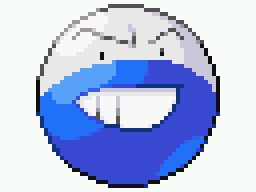

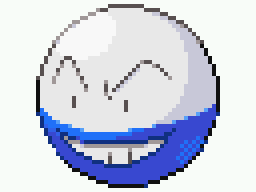

In [5]:
#file_to_img("./DS DSi - Pokemon Platinum - Pokemon 1st Generation.png.dir/000_small_1.bin", 32, 24)
file_to_img("./DS DSi - Pokemon Platinum - Pokemon 1st Generation.png.dir/115_shiny_1.bin", 64, 48)
file_to_img("./DS DSi - Pokemon HeartGold SoulSilver - Pokemon 1st Generation.png.dir/115_shiny_1.bin", 64, 48)


## PW Greyscale

In [6]:
def rgb_to_pw_greyscale(rgb):
    converter = np.array([0.296, 0.590, 0.114], dtype=np.float32)
    rgb = rgb.astype(np.float32)
    print(rgb[0])
    
    rgb[np.where(rgb == [84, 165, 75])] = 255. ## replace this colour with pure white
    vals = np.matmul(rgb, converter)
    
    pw = np.full(len(vals), -1, dtype=np.uint8)
    
    #levels = [0, 87.696, 143.856, 199.952, 248.0]
    levels = [0, 87.696, 143.856, 199.952, 255.0]
    pw[np.where( (vals >= levels[0]) & (vals < levels[1]) )] = 3
    pw[np.where( (vals >= levels[1]) & (vals < levels[2]) )] = 2
    pw[np.where( (vals >= levels[2]) & (vals < levels[3]) )] = 1
    pw[np.where( (vals >= levels[3]) & (vals <= levels[4]) )] = 0
    
    import sys
    with  np.printoptions(threshold=99999999):
        #print(vals)
        print(pw)
    
    return pw
 
img = Image.open("./DS DSi - Pokemon Platinum - Pokemon 1st Generation.png")
img = img.crop((1, 34, 81, 115))
arr = np.array(img)
arr = arr[...,:3]
arr = arr.reshape((-1,3))
_ = rgb_to_pw_greyscale(arr)

[ 84. 165.  75.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

## Size calculations

In [7]:
def size_calcs():
    n_forms = 173 + 136 + 158 + 179
    
    small_size = 16*2 + (24*32)//2 # 16 2-byte colours plus 2 pixels per byte
    normal_size = 16*2 + (64*48)//2 # 16 2-byte colours plus 2 pixels per byte
    
    total_size = n_forms * (small_size*2 + normal_size*4) # 2 frames each, small, normal and shiny
    
    print(f"Total size taken up by compressed sprites: {total_size/(1024**2)}MiB")
size_calcs()

Total size taken up by compressed sprites: 4.3765869140625MiB


## Custom sprites by @zenithknight

In [8]:
directory = "./walker-color"
n_files = len(os.listdir(directory))
colours16 = np.zeros((n_files, 16), dtype=np.uint16)
indexed = np.zeros((n_files, (64*96)//2), dtype=np.uint8)

for i, fname in enumerate(sorted(os.listdir(directory))):
    #print(img.size)
    with Image.open(directory+"/"+fname) as img:
        _, colours16[i], indexed[i] = img_to_palette(img)
    file_bytes = bytearray(colours16[i]) + bytearray(indexed[i])
    with open(f"{directory}-converted/{fname}.bin", "wb") as f:
        f.write(file_bytes)
      

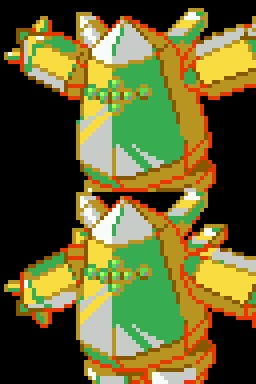

378 Regice with colours of 178 Xatu


In [19]:
ipalette, idata = np.random.randint(low=0, high=n_files, size=2)

lols = bytearray(colours16[ipalette]) + bytearray(indexed[idata])
with open("swapped.bin", "wb") as f:
    f.write(lols)
file_to_img("./swapped.bin", 64, 96)

with open("./mapped-sprites.json") as m:
    name_map = json.load(m)
#print(name_map)
print(f"{name_map[f'6_{idata:03}']} with colours of {name_map[f'6_{ipalette:03}']}")

## RLE

Format is an array of bytes, broken into 4-bit sections.

Some sprites have entries with a run length of more than 255, so either need a u16 to store the run length, or break entries up into smaller run lengths.

Decide to have max run length of 15, so that (value, length) can be packed into a u8.
This is, on average, less space than an array of (u8, u8)

- High 4-bits = colour index
- Low 4-bits = run length

Final data sctucture something like
```c
struct image {
    u16 size;
    u16 palette[16];
    u8  data[size];
}
```

In [10]:
def do_rle(data):
    flat = np.zeros(len(data)*2) # 1 byte per index
    for i, v in enumerate(data):
        flat[2*i] = v>>4
        flat[2*i+1] = v&0x0f

    #rle = pyrle.Rle(flat)
    rle = [(k,sum([1 for i in g])) for k,g in groupby(flat)] ## stolen from https://stackoverflow.com/questions/43424729/how-to-find-run-length-encoding-in-python
    
    packed = []
    for v, n in rle:
        v = int(v)
        while n > 15:
            packed.append((v,15))
            n -= 15
        packed.append((v,n))
        
    packed_size = len(packed)
    packed_bytes = np.zeros(packed_size, dtype=np.uint8)
    for i, (v, l) in enumerate(packed):
        packed_bytes[i] = (v<<4) | (l&0x0f)
    
    return rle, packed_bytes

In [11]:
pkidx = np.random.randint(low=0, high=n_files)
compression_ratios = np.zeros(n_files)
file_sizes = np.zeros(n_files, dtype=np.uint16)

for pkidx in range(n_files):
    unpacked, packed = do_rle(indexed[pkidx])

    flat_size = len(indexed[pkidx]) ## 0.5 bytes per entry (2 entries per byte)
    unpacked_size = 2*len(unpacked) ## 2 bytes per entry (minimum)
    packed_size = len(packed) ## 1 byte per entry
    file_sizes[pkidx] = packed_size + 2 + 32 ## 2 bytes for len, 2*16 bytes for palette

    original_size = (64*48*2)*2 # 64x48 image, 2 frames, 2 bytes per pixel
    compression_ratios[pkidx] = original_size / packed_size
    
    #print(f"flat size: {flat_size}\n(minimum) unpacked size: {unpacked_size}\npacked size: {packed_size}")
    print(f"6_{pkidx:03} Compression ratio: {original_size/packed_size:.1f}x")
    
    
    
    fdata = bytearray(packed_size.to_bytes(2, byteorder='little')) + bytearray(colours16[pkidx]) + bytearray(packed)
    with open(f"walker-color-rle/large_normal_{pkidx:03}.bin", "wb") as f:
        f.write(fdata)

    #img = Image.open(f"walker-color/6_{pkidx:03}.png")
    #display(img.resize(resample=Resampling.BOX, size=(img.width*4, img.height*4)))



6_000 Compression ratio: 10.4x
6_001 Compression ratio: 8.1x
6_002 Compression ratio: 5.5x
6_003 Compression ratio: 10.3x
6_004 Compression ratio: 8.2x
6_005 Compression ratio: 7.1x
6_006 Compression ratio: 10.3x
6_007 Compression ratio: 6.8x
6_008 Compression ratio: 6.5x
6_009 Compression ratio: 11.3x
6_010 Compression ratio: 14.0x
6_011 Compression ratio: 7.8x
6_012 Compression ratio: 12.4x
6_013 Compression ratio: 11.8x
6_014 Compression ratio: 6.7x
6_015 Compression ratio: 10.0x
6_016 Compression ratio: 6.9x
6_017 Compression ratio: 9.6x
6_018 Compression ratio: 10.7x
6_019 Compression ratio: 7.3x
6_020 Compression ratio: 10.8x
6_021 Compression ratio: 6.9x
6_022 Compression ratio: 9.3x
6_023 Compression ratio: 7.7x
6_024 Compression ratio: 10.6x
6_025 Compression ratio: 8.5x
6_026 Compression ratio: 9.2x
6_027 Compression ratio: 7.1x
6_028 Compression ratio: 11.6x
6_029 Compression ratio: 8.0x
6_030 Compression ratio: 7.1x
6_031 Compression ratio: 9.8x
6_032 Compression ratio: 6.7

6_273 Compression ratio: 9.5x
6_274 Compression ratio: 6.2x
6_275 Compression ratio: 14.0x
6_276 Compression ratio: 8.0x
6_277 Compression ratio: 14.1x
6_278 Compression ratio: 8.3x
6_279 Compression ratio: 13.4x
6_280 Compression ratio: 9.0x
6_281 Compression ratio: 9.3x
6_282 Compression ratio: 11.5x
6_283 Compression ratio: 9.0x
6_284 Compression ratio: 12.6x
6_285 Compression ratio: 7.6x
6_286 Compression ratio: 9.9x
6_287 Compression ratio: 7.7x
6_288 Compression ratio: 6.2x
6_289 Compression ratio: 10.1x
6_290 Compression ratio: 8.5x
6_291 Compression ratio: 9.0x
6_292 Compression ratio: 11.9x
6_293 Compression ratio: 6.1x
6_294 Compression ratio: 5.4x
6_295 Compression ratio: 9.3x
6_296 Compression ratio: 7.4x
6_297 Compression ratio: 10.1x
6_298 Compression ratio: 9.6x
6_299 Compression ratio: 9.1x
6_300 Compression ratio: 7.9x
6_301 Compression ratio: 8.9x
6_302 Compression ratio: 6.9x
6_303 Compression ratio: 11.6x
6_304 Compression ratio: 6.5x
6_305 Compression ratio: 5.8x
6

6_550 Compression ratio: 10.9x
6_551 Compression ratio: 5.3x
6_552 Compression ratio: 7.7x
6_553 Compression ratio: 6.7x
6_554 Compression ratio: 7.6x
6_555 Compression ratio: 8.4x
6_556 Compression ratio: 9.5x
6_557 Compression ratio: 8.8x
6_558 Compression ratio: 6.5x
6_559 Compression ratio: 7.3x
6_560 Compression ratio: 10.7x
6_561 Compression ratio: 8.1x
6_562 Compression ratio: 5.8x
6_563 Compression ratio: 9.3x
6_564 Compression ratio: 8.0x
6_565 Compression ratio: 9.8x
6_566 Compression ratio: 8.2x
6_567 Compression ratio: 10.7x
6_568 Compression ratio: 9.4x
6_569 Compression ratio: 8.8x
6_570 Compression ratio: 7.3x
6_571 Compression ratio: 12.2x
6_572 Compression ratio: 9.7x
6_573 Compression ratio: 9.7x
6_574 Compression ratio: 10.3x
6_575 Compression ratio: 7.4x
6_576 Compression ratio: 8.4x
6_577 Compression ratio: 7.5x
6_578 Compression ratio: 6.7x
6_579 Compression ratio: 9.6x
6_580 Compression ratio: 8.6x
6_581 Compression ratio: 6.8x
6_582 Compression ratio: 10.3x
6_58

In [12]:
max_ratio_idx = np.argmax(compression_ratios)
min_ratio_idx = np.argmin(compression_ratios)
print(f"max compression ratio: {name_map[f'6_{max_ratio_idx:03}']}, {compression_ratios[max_ratio_idx]:.1f}x")
print(f"min compression ratio: {name_map[f'6_{min_ratio_idx:03}']}, {compression_ratios[min_ratio_idx]:.1f}x")
print(f"average compressoin ratio: {np.mean(compression_ratios):.1f}x")

total_original_size = (64*48*2)*2*n_files
total_compressed_size = np.sum(file_sizes)
print(f"Total original size: {total_original_size/(1024**2):.2f}MiB")
print(f"Total compressed size: {total_compressed_size/(1024**2):.2f}MiB")
print(f"Total compression ratio: {total_original_size/total_compressed_size:.1f}x")

max compression ratio: 201 Unown, 18.0x
min compression ratio: 130 Gyarados (Female), 4.9x
average compressoin ratio: 9.1x
Total original size: 7.78MiB
Total compressed size: 0.93MiB
Total compression ratio: 8.4x


In [13]:
def rle_decode(fname, w, h):
    with open(fname, "rb") as f:
        raw_data = bytes(f.read())
        
        ## decode data structure
        dlen = int.from_bytes(raw_data[:2], byteorder='little')
        palette = np.frombuffer(raw_data[2:34], dtype=np.uint16)
        palette_rgb = np.empty((len(palette), 3), dtype=np.uint8)
        raw_data = raw_data[34:]
        
        ## create output buffers
        data = np.empty(w*h, dtype=np.uint16)
        cdata = np.empty((w*h, 3), dtype=np.uint8)
        
        ## convert 565 palette to rgb
        for i, v in enumerate(palette):
            palette_rgb[i][0] = ((v>>11)&0x1f)<<3
            palette_rgb[i][1] = ((v>>5)&0x3f)<<2
            palette_rgb[i][2] = ((v>>0)&0x1f)<<3
        
        ## actually decode the data
        cursor = 0
        for i, v in enumerate(raw_data):
            c = (v>>4)&0x0f
            r = v&0x0f
            data[cursor:cursor+r] = palette[c]
            cdata[cursor:cursor+r] = palette_rgb[c]
            cursor += r
            
        ## display the RGB data
        cdata = cdata.reshape((h,w,3))
        img = Image.fromarray(cdata, mode="RGB")
        display(img.resize(resample=Resampling.BOX, size=(img.width*4, img.height*4)))
    return img

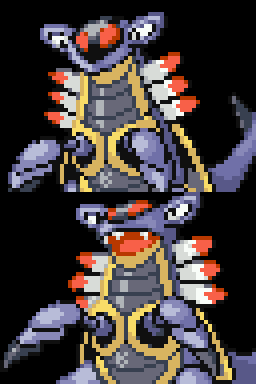

In [14]:
_ = rle_decode("./walker-color-rle/large_normal_347.bin", 64, 48*2)